#Imports

In [ ]:
import librosa
import audioread
import numpy as np
import scipy
import scipy.signal
import collections
import matplotlib.pyplot as plt
import os.path
#import IPython.display
%matplotlib inline

#Definitions

In [2]:
''' for faster speeds you may want to convert the files BEFORE.
ffmpeg -i "infile" -acodec pcm_s16le -ac 1 -ar 16000 "outfile"
'''

filename = "mix.wav"
sr = 16000
framesize = 2**12
n_blocks = 64
feature_dim = 80

kernel_size = 60

feature_buffer = collections.deque() #maxlen=horizon * n_blocks
rec_buffer = collections.deque() 

#Functions

In [3]:
def get_audiofile_duration(file):
    with audioread.audio_open(file) as f:
        return f.duration

In [4]:
def create_kernel(size):
    kernel = np.zeros([2*kernel_size+1, 2*kernel_size+1], dtype='int')
    kernel[:kernel_size, :kernel_size] = 1
    kernel[kernel_size+1:, kernel_size+1:] = 1
    kernel[kernel_size+1:, :kernel_size] = -1
    kernel[:kernel_size, kernel_size+1:] = -1
    return kernel

# Main Program

In [ ]:
blocksize = n_blocks * framesize/sr #seconds

#horizon = 4 * n_blocks 
horizon = 2*(2*kernel_size+1)
horizon_step = horizon // 2

#make sure there is enough data for the filter
assert horizon_step >= 2*kernel_size+1 

duration = get_audiofile_duration(filename)
segments = np.arange(0, duration, blocksize)

kernel = create_kernel(kernel_size)

# initalize and clear all buffers
feature_buffer.clear()
rec_buffer.clear()
novelty_buffer = []
novelty_calc_matrix = np.zeros((2*horizon, 2*horizon))

# iterate through the whole file
for i, block in enumerate(segments):
    
    print("@block: ", block)
    
    # load chunk of audio file (~300ms)
    y = librosa.load(filename, sr=sr, mono=True, offset=block, duration=blocksize)[0]
    
    # constant Q transform (~1500ms)
    CQ = librosa.core.cqt(y, sr=sr, hop_length=framesize, fmin=None, n_bins=feature_dim, bins_per_octave=12, tuning=None, resolution=2, aggregate=None, norm=1, sparsity=0.01)
    feature_buffer.extend(CQ.T)
 
    while len(feature_buffer) >= horizon:
        features = [feature_buffer.popleft() for x in range(0, horizon_step)]
        features.extend(list(feature_buffer)[:horizon_step])
        
        # compute recurrence matrix (~16ms)
        R_CQ = librosa.segment.recurrence_matrix(np.array(features).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
        rec_buffer.extend(R_CQ)
    
    while len(rec_buffer) >= 3*horizon:
        
        # fill the matrix for the calculation
        if novelty_buffer: # only ommit if empty
            novelty_calc_matrix[:horizon, :horizon] = [rec_buffer.popleft() for x in range(0, horizon)]
        novelty_calc_matrix[horizon_step:horizon+horizon_step, horizon_step:horizon+horizon_step] = np.array(list(rec_buffer)[:horizon])
        novelty_calc_matrix[horizon:2*horizon, horizon:2*horizon] = np.array(list(rec_buffer)[horizon:2*horizon])
        
        # calculate the novelty
        lower_limit = horizon_step - kernel_size
        upper_limit = horizon + kernel_size
        #novelty = scipy.signal.convolve2d(novelty_calc_matrix[lower_limit:upper_limit, lower_limit:upper_limit], kernel, mode='valid')
        novelty = scipy.signal.fftconvolve(novelty_calc_matrix[lower_limit:upper_limit, lower_limit:upper_limit], kernel, mode='valid')

        novelty_buffer.extend(novelty.diagonal())
        

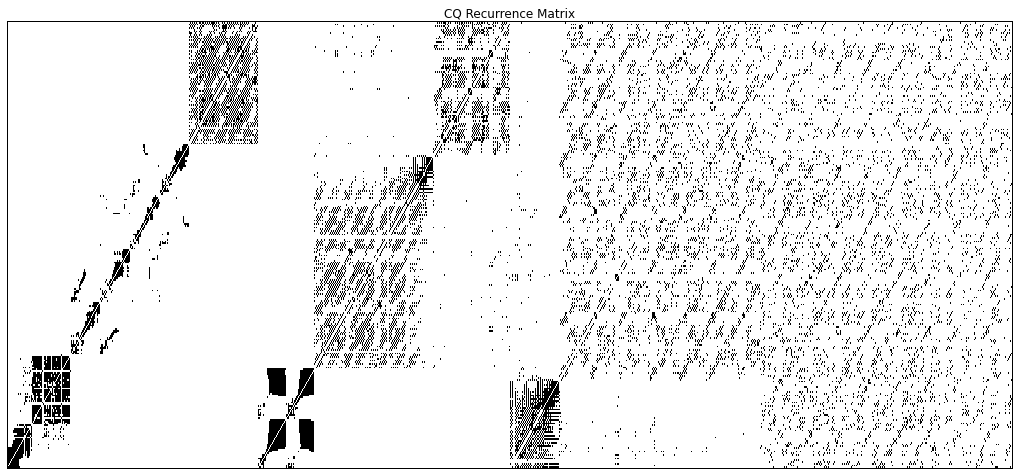

In [77]:
plt.figure(figsize=(18,8))

librosa.display.specshow(np.array(recurrence_buffer).T)

plt.title('CQ Recurrence Matrix')

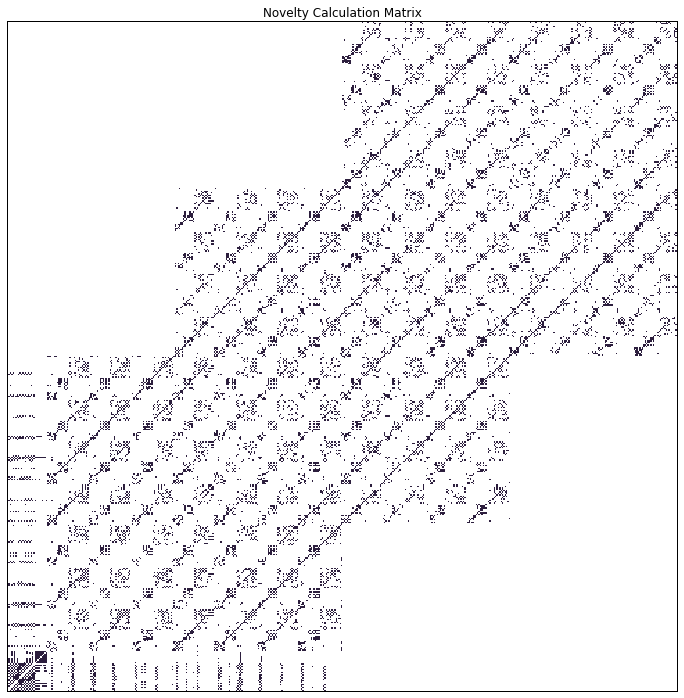

In [74]:
plt.figure(figsize=(12,12))

librosa.display.specshow(np.array(novelty_calc_matrix).T)

plt.title('Novelty Calculation Matrix')

#Plot Novelty

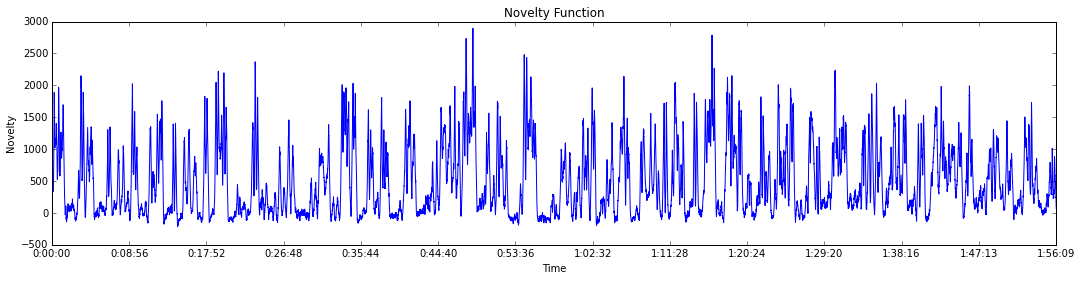

In [6]:
plt.figure(figsize=(18,4))
plt.title("Novelty Function")
plt.plot(novelty_buffer)
plt.ylabel('Novelty')
plt.xlabel('Time')
locs = np.arange(0, len(novelty_buffer))
plt.xlim([locs[0], locs[-1]])
librosa.display.time_ticks(locs, librosa.core.samples_to_time(locs, sr=sr/framesize), n_ticks=14)
plt.show()